## UE20CS344: Network Analysis and Mining

#### Course Project: Recommender System by Link Prediction using Algorithms and GNN

#### Importing necessary libraries

In [179]:
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import kernighan_lin_bisection, louvain_communities
from networkx.algorithms.community.label_propagation import label_propagation_communities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams

#### Miscellaneous functions

In [180]:
def newColorHex():
    color = '#'
    for i in range(6):
        color += np.random.choice(list("6789ABCD"))
    return color

#### Reading CSV files containing relations between people and the products they bought

In [181]:
edgelist_df = pd.read_csv('data/relations.csv')
people_df = pd.read_csv('data/people.csv')
names = people_df.set_index('id').T.to_dict('list')
names = {k: v[0] for k, v in names.items()}


purchases = pd.read_csv('data/purchases.csv')
products = pd.read_csv('data/products.csv').set_index('id').T.to_dict()
product_names = {k: v['product'] for k, v in products.items() if k in purchases['product_id'].unique()}
product_prices = {k: int(v['price']) for k, v in products.items() if k in purchases['product_id'].unique()}

### Plotting relations between people

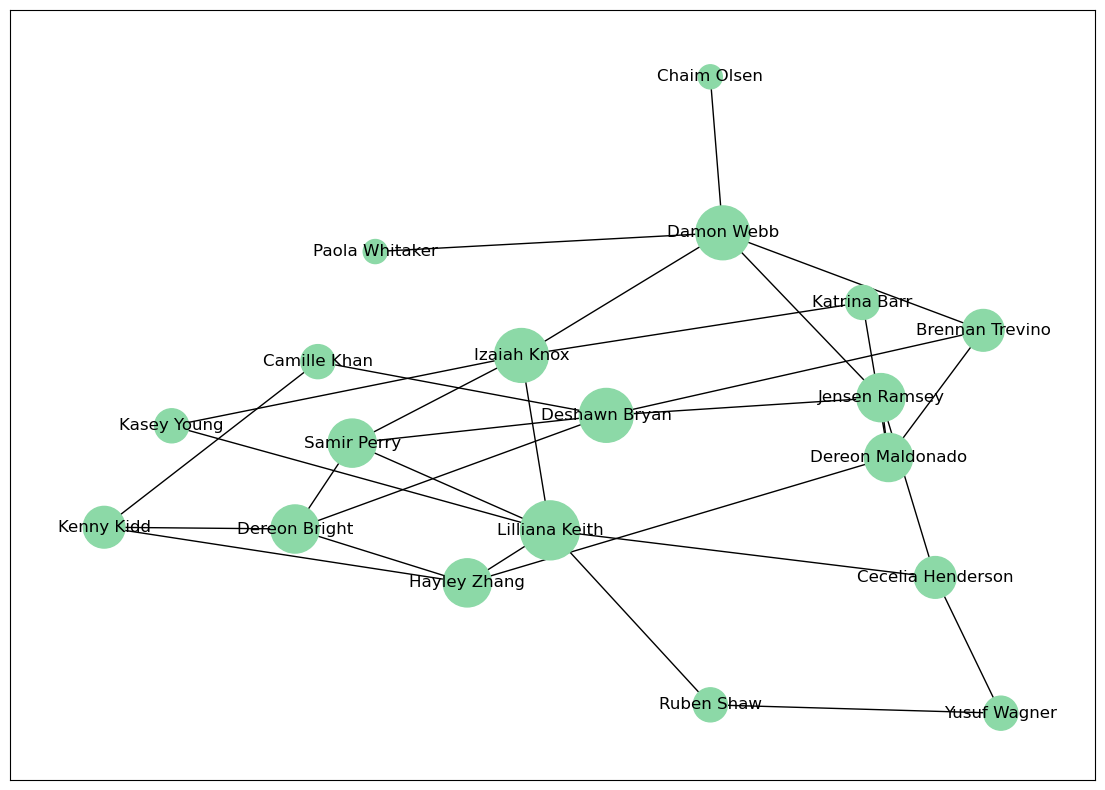

In [182]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist_df, source='id1', target='id2')
G = nx.relabel_nodes(G, names)

rcParams['figure.figsize'] = 14, 10
pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
d = dict(G.degree)
nx.draw_networkx(G, pos, node_color=newColorHex(),
        with_labels=True,
        nodelist=d,
        node_size=[d[k]*300 for k in d])

### Finding communities

#### Partitioning the set of people via centraility measures (Girvan-Newman algorithm)

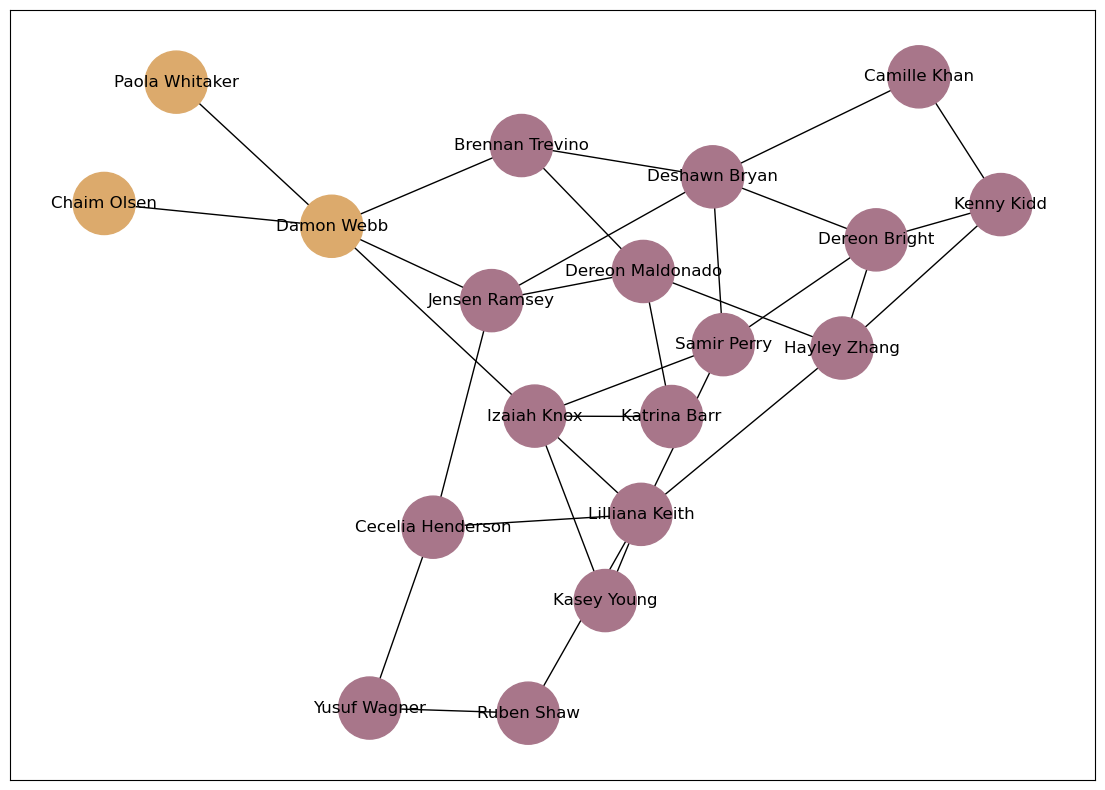

In [183]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist_df, source='id1', target='id2')
G = nx.relabel_nodes(G, names)

communities = girvan_newman(G)

node_groups = []
for com in next(communities):
    node_groups.append(set(com))

group_colors = [newColorHex() for _ in node_groups]

color_map = []
for node in G:
    for group_num in range(len(node_groups)):
        if node in node_groups[group_num]:
            color_map.append(group_colors[group_num])

plt.figure(5, figsize=(14, 10))
nx.draw_networkx(G, node_color=color_map, with_labels=True, node_size=2000)

#### Finding bipartitions (Kernighan-Lin bipartition algorithm)

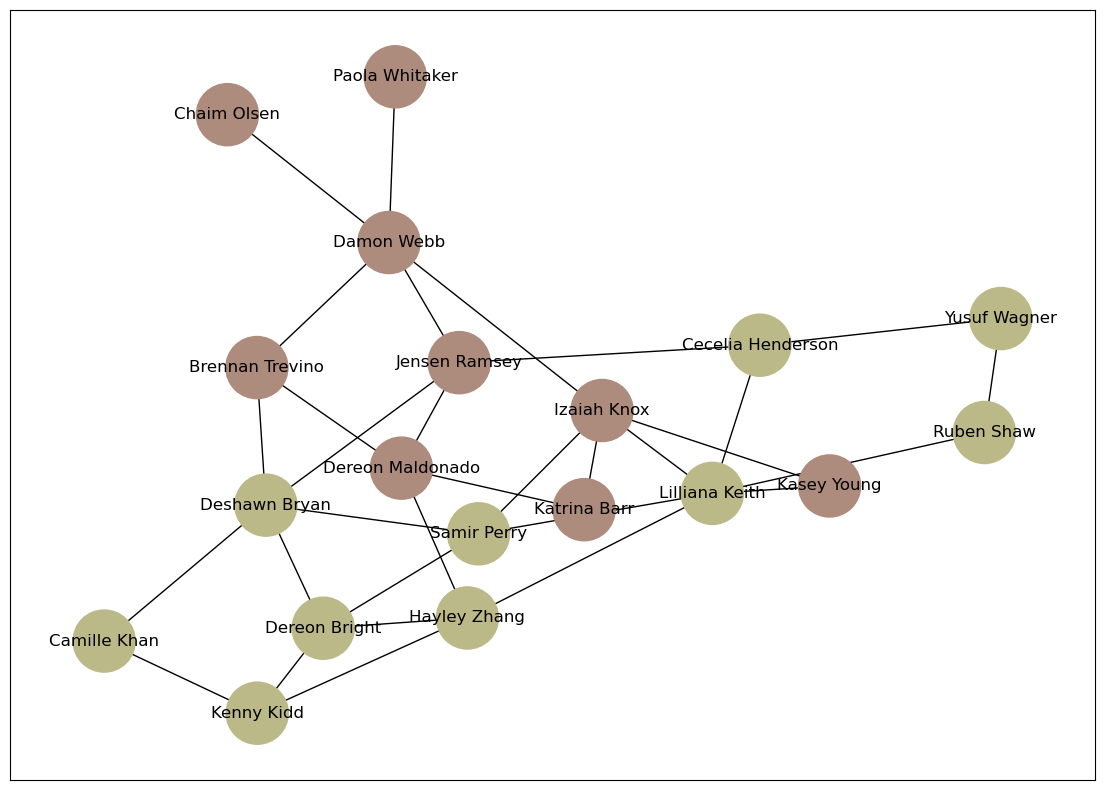

In [184]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist_df, source='id1', target='id2')
G = nx.relabel_nodes(G, names)

communities = kernighan_lin_bisection(G)

node_groups = []
for com in communities:
    node_groups.append(com)

group_colors = [newColorHex() for _ in node_groups]

color_map = []
for node in G:
    for group_num in range(len(node_groups)):
        if node in node_groups[group_num]:
            color_map.append(group_colors[group_num])

plt.figure(5, figsize=(14, 10))
nx.draw_networkx(G, node_color=color_map, with_labels=True, node_size=2000)

#### Finding communities using label propagation community detection algorithm

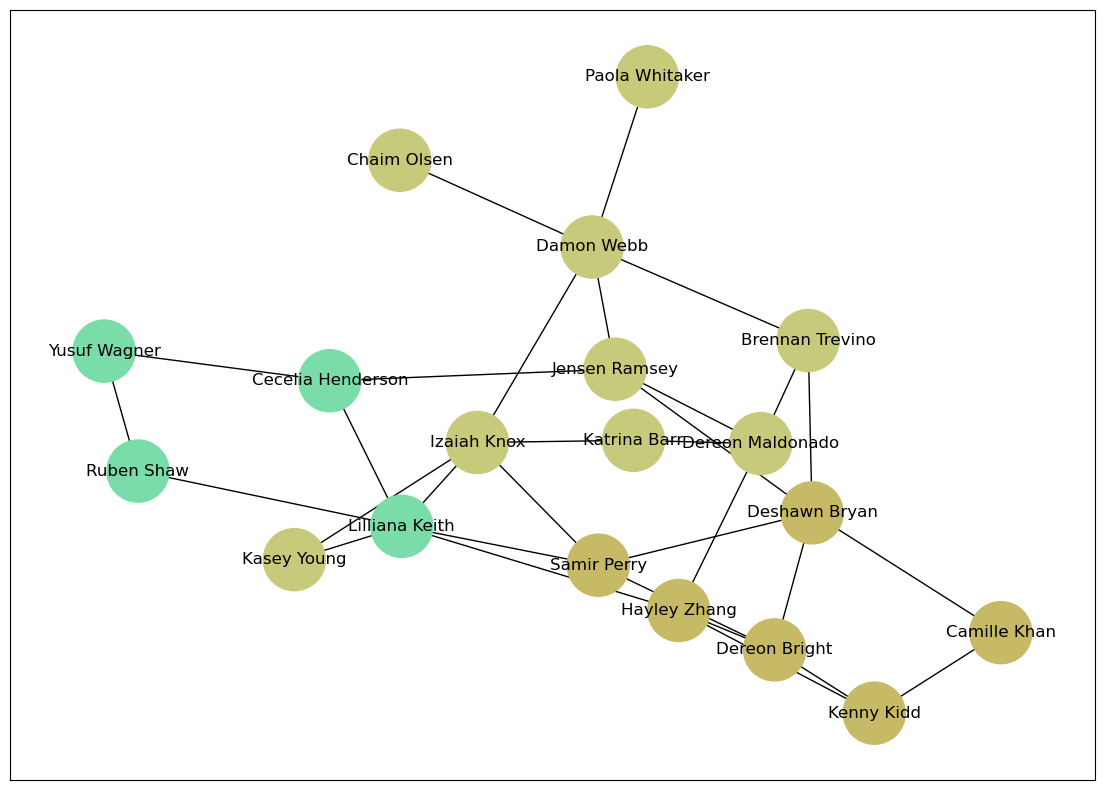

In [185]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist_df, source='id1', target='id2')
G = nx.relabel_nodes(G, names)

communities = label_propagation_communities(G)

node_groups = []
for com in communities:
    node_groups.append(com)

group_colors = [newColorHex() for _ in node_groups]

color_map = []
for node in G:
    for group_num in range(len(node_groups)):
        if node in node_groups[group_num]:
            color_map.append(group_colors[group_num])

plt.figure(5, figsize=(14, 10))
nx.draw_networkx(G, node_color=color_map, with_labels=True, node_size=2000)

#### Detecting communities using the Louvain community detection algorithm

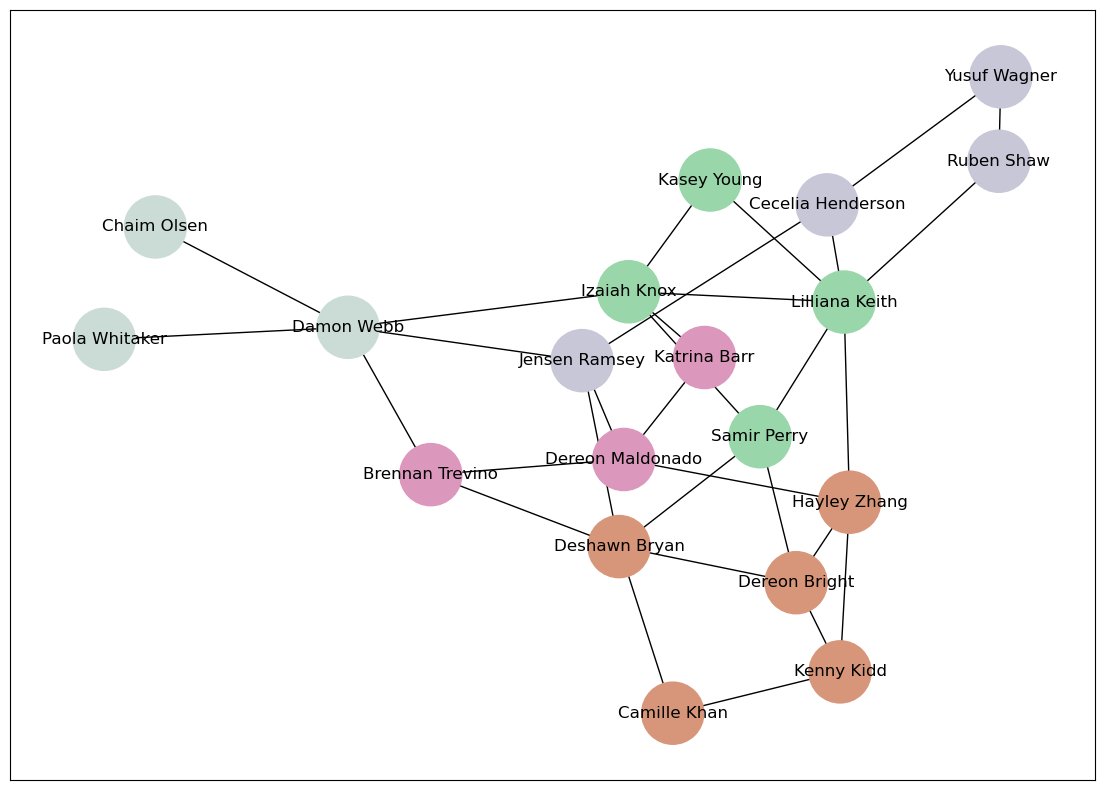

In [186]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist_df, source='id1', target='id2')
G = nx.relabel_nodes(G, names)

communities = louvain_communities(G)

node_groups = []
for com in communities:
    node_groups.append(com)

group_colors = [newColorHex() for _ in node_groups]

color_map = []
for node in G:
    for group_num in range(len(node_groups)):
        if node in node_groups[group_num]:
            color_map.append(group_colors[group_num])

plt.figure(5, figsize=(14, 10))
nx.draw_networkx(G, node_color=color_map, with_labels=True, node_size=2000)

### Plotting people and their purchases

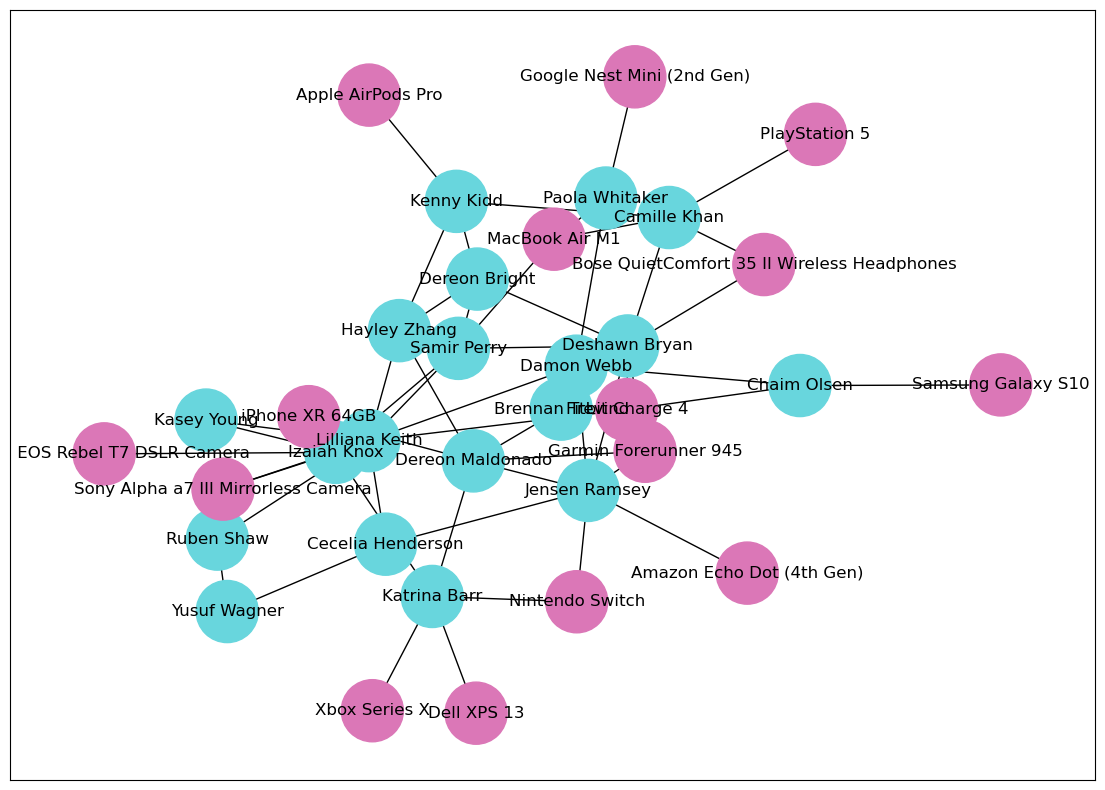

In [187]:
G = nx.Graph()
G.add_edges_from(edgelist_df.values)
G.add_edges_from(purchases.values)

person_nodes = set(people_df.id.tolist())
product_nodes = set(purchases.product_id)

person_color = newColorHex()
product_color = newColorHex()

color_map = []
for node in G:
    if node in person_nodes:
        color_map.append(person_color)
    elif node in product_nodes:
        color_map.append(product_color)

G = nx.relabel_nodes(G, names)
G = nx.relabel_nodes(G, product_names)

plt.figure(5, figsize=(14, 10))
nx.draw_networkx(G, node_color=color_map, with_labels=True, node_size=2000)

## Link Prediction using Algorithms

#### Using resource allocation index

In [188]:
G = nx.Graph()
G.add_edges_from(edgelist_df.values)
G.add_edges_from(purchases.values)

ebunch = []
for node1 in G:
    for node2 in G:
        if node1 != node2 and (node1, node2) not in G.edges and (node2, node1) not in G.edges:
            if node1 in person_nodes and node2 in product_nodes:
                ebunch.append((node1, node2))

iterator_list = list(nx.resource_allocation_index(G, ebunch=ebunch))
iterator_list_sorted = sorted(iterator_list, key=lambda x: x[2], reverse=True)
rai_predictions = list(map(lambda x: (names[x[0]], product_names[x[1]], x[2]), iterator_list_sorted))

df_predictions = pd.DataFrame(rai_predictions, columns=['person', 'product', 'resource_allocation_index'])
df_predictions

,person,product,resource_allocation_index
0,Deshawn Bryan,MacBook Air M1,0.400000
1,Dereon Maldonado,Nintendo Switch,0.342857
2,Damon Webb,Fitbit Charge 4,0.333333
3,Damon Webb,Samsung Galaxy S10,0.333333
4,Damon Webb,MacBook Air M1,0.333333
...,...,...,...
253,Paola Whitaker,Bose QuietComfort 35 II Wireless Headphones,0.000000
254,Paola Whitaker,PlayStation 5,0.000000
255,Paola Whitaker,Apple AirPods Pro,0.000000
256,Paola Whitaker,Dell XPS 13,0.000000


#### Using Jaccard coefficient

In [189]:
G = nx.Graph()
G.add_edges_from(edgelist_df.values)
G.add_edges_from(purchases.values)

ebunch = []
for node1 in G:
    for node2 in G:
        if node1 != node2 and (node1, node2) not in G.edges and (node2, node1) not in G.edges:
            if node1 in person_nodes and node2 in product_nodes:
                ebunch.append((node1, node2))

jaccard_coefficients_list = list(nx.jaccard_coefficient(G, ebunch=ebunch))
jaccard_coefficients_sorted = sorted(jaccard_coefficients_list, key=lambda x: x[2], reverse=True)
jaccard_predictions = list(map(lambda x: (names[x[0]], product_names[x[1]], x[2]), jaccard_coefficients_sorted))

df_jaccard_predictions = pd.DataFrame(jaccard_predictions, columns=['person', 'product', 'jaccard_coefficient'])
df_jaccard_predictions

,person,product,jaccard_coefficient
0,Kasey Young,iPhone XR 64GB,0.666667
1,Kasey Young,Sony Alpha a7 III Mirrorless Camera,0.666667
2,Kasey Young,Canon EOS Rebel T7 DSLR Camera,0.500000
3,Brennan Trevino,Garmin Forerunner 945,0.500000
4,Hayley Zhang,iPhone XR 64GB,0.400000
...,...,...,...
253,Paola Whitaker,Bose QuietComfort 35 II Wireless Headphones,0.000000
254,Paola Whitaker,PlayStation 5,0.000000
255,Paola Whitaker,Apple AirPods Pro,0.000000
256,Paola Whitaker,Dell XPS 13,0.000000


#### Using Adamic-Adar index

In [190]:
G = nx.Graph()
G.add_edges_from(edgelist_df.values)
G.add_edges_from(purchases.values)

ebunch = []
for node1 in G:
    for node2 in G:
        if node1 != node2 and (node1, node2) not in G.edges and (node2, node1) not in G.edges:
            if node1 in person_nodes and node2 in product_nodes:
                ebunch.append((node1, node2))

iterator_list = list(nx.resource_allocation_index(G, ebunch=ebunch))
iterator_list_sorted = sorted(iterator_list, key=lambda x: x[2], reverse=True)
aai_predictions = list(map(lambda x: (names[x[0]], product_names[x[1]], x[2]), iterator_list_sorted))

df_predictions = pd.DataFrame(aai_predictions, columns=['person', 'product', 'adamic_adar_index'])
df_predictions

,person,product,adamic_adar_index
0,Deshawn Bryan,MacBook Air M1,0.400000
1,Dereon Maldonado,Nintendo Switch,0.342857
2,Damon Webb,Fitbit Charge 4,0.333333
3,Damon Webb,Samsung Galaxy S10,0.333333
4,Damon Webb,MacBook Air M1,0.333333
...,...,...,...
253,Paola Whitaker,Bose QuietComfort 35 II Wireless Headphones,0.000000
254,Paola Whitaker,PlayStation 5,0.000000
255,Paola Whitaker,Apple AirPods Pro,0.000000
256,Paola Whitaker,Dell XPS 13,0.000000


#### Using common neighbour and centrality based parameterized algorithm score

In [191]:
G = nx.Graph()
G.add_edges_from(edgelist_df.values)
G.add_edges_from(purchases.values)

ebunch = []
for node1 in G:
    for node2 in G:
        if node1 != node2 and (node1, node2) not in G.edges and (node2, node1) not in G.edges:
            if node1 in person_nodes and node2 in product_nodes:
                ebunch.append((node1, node2))

iterator_list = list(nx.common_neighbor_centrality(G, ebunch=ebunch, alpha=0.8)) # default value alpha = 0.8
iterator_list_sorted = sorted(iterator_list, key=lambda x: x[2], reverse=True)
ccpa_predictions = list(map(lambda x: (names[x[0]], product_names[x[1]], x[2]), iterator_list_sorted))

df_predictions = pd.DataFrame(ccpa_predictions, columns=['person', 'product', 'ccpa_score'])
df_predictions

,person,product,ccpa_score
0,Kasey Young,iPhone XR 64GB,5.00
1,Kasey Young,Sony Alpha a7 III Mirrorless Camera,5.00
2,Hayley Zhang,iPhone XR 64GB,5.00
3,Dereon Maldonado,Nintendo Switch,5.00
4,Samir Perry,iPhone XR 64GB,5.00
...,...,...,...
253,Yusuf Wagner,Google Nest Mini (2nd Gen),1.36
254,Yusuf Wagner,Dell XPS 13,1.36
255,Yusuf Wagner,Xbox Series X,1.36
256,Ruben Shaw,PlayStation 5,1.36


## Link Prediction using Graph Convolutional Neural Network

#### Importing necessary libraries

In [192]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl.data import DGLDataset
from dgl.nn import SAGEConv
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score

#### Creating DGL graph dataset

In [193]:
class GraphDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='shopping')
    
    def process(self):
        nodes_data = pd.DataFrame()
        people_df = pd.read_csv('data/ids_gcn.csv')
        nodes_data['id'] = people_df.id.tolist()

        edges_data = pd.DataFrame()
        relations_df = pd.read_csv('data/relations_gcn.csv')
        edges_data['src'] = relations_df.id1.tolist()
        edges_data['dst'] = relations_df.id2.tolist()

        self.graph = dgl.graph((edges_data.src, edges_data.dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['feat'] = torch.tensor([1 for _ in range(nodes_data.shape[0])], dtype=torch.float32)
        self.graph.edata['weight'] = torch.tensor([1 for _ in range(edges_data.shape[0])], dtype=torch.float32)

    def __getitem__(self, idx):
        return self.graph
    
    def __len__(self):
        return 1
    
dataset = GraphDataset()
g = dataset[0]

g

Graph(num_nodes=20, num_edges=34,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})

#### Preparing training and testing sets

In [194]:
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]


In [195]:
train_g = dgl.remove_edges(g, eids[:test_size])

#### Defining a GraphSAGE model

In [196]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

#### Creating positive and negative graphs for the training and testing sets respectively

In [197]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

#### Computing new edge features based on existing node/edge features

Here, we make use of `dgl.function.u_dot_v`, which is a builtin function.

In [198]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score']

#### Adding evaluation metrics

In [199]:
model = GraphSAGE(train_g.ndata['feat'].shape[0], train_g.ndata['feat'].shape[0])
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

def compute_acc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return ((scores > 0) == labels).float().sum() / len(labels)

#### Training loop

Optimizer

In [200]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

Training with `compute_loss` as the loss function, which makes use of the area under the receiver operating characteristic curve.

In [201]:
epochs = 10000

losses = []
accs = []

for e in range(epochs):
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    acc = compute_acc(pos_score, neg_score)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 50 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))
    
    losses.append(loss.item())
    accs.append(acc.item())

In epoch 0, loss: 1.6623929738998413
In epoch 50, loss: 0.3816334009170532


In epoch 100, loss: 0.35364893078804016
In epoch 150, loss: 0.39916759729385376
In epoch 200, loss: 0.3386385142803192
In epoch 250, loss: 0.3668276071548462
In epoch 300, loss: 0.33850714564323425
In epoch 350, loss: 0.3265864849090576
In epoch 400, loss: 0.3852061629295349
In epoch 450, loss: 0.3466254770755768
In epoch 500, loss: 0.3309299349784851
In epoch 550, loss: 0.3244789242744446
In epoch 600, loss: 0.3922436833381653
In epoch 650, loss: 0.3733416497707367
In epoch 700, loss: 0.35211968421936035
In epoch 750, loss: 0.3352943956851959
In epoch 800, loss: 0.32908058166503906
In epoch 850, loss: 0.32554805278778076
In epoch 900, loss: 0.3257969915866852
In epoch 950, loss: 0.3330743908882141
In epoch 1000, loss: 0.3255636394023895
In epoch 1050, loss: 0.32248029112815857
In epoch 1100, loss: 0.3808452785015106
In epoch 1150, loss: 0.33031365275382996
In epoch 1200, loss: 0.3243449628353119
In epoch 1250, loss: 0.3213667571544647
In epoch 1300, loss: 0.4346231520175934
In epoch 1

#### Results

In [202]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print(f'Area under ROC: {compute_auc(pos_score, neg_score)}')
    print(f'Accuracy: {compute_acc(pos_score, neg_score)}')

Area under ROC: 0.6666666666666666
Accuracy: 0.8333333134651184


Plotting loss and accuracy against epochs

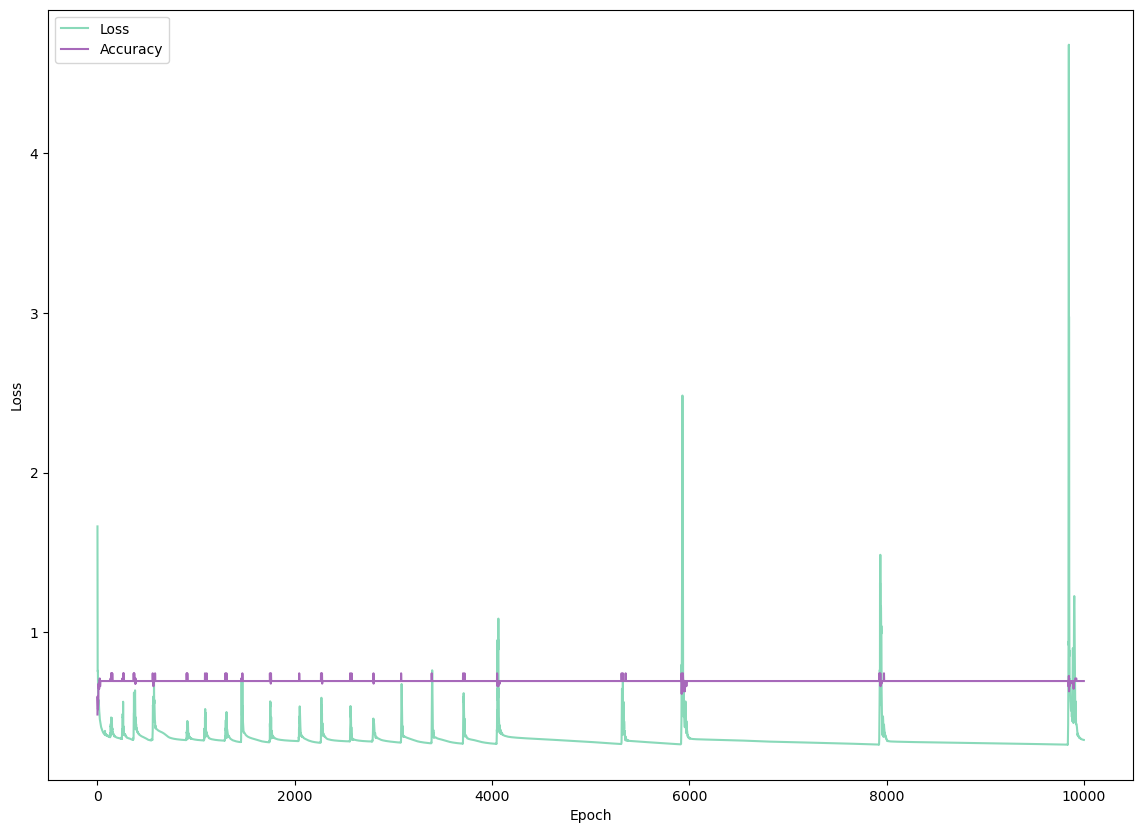

In [203]:
plt.plot(losses, color=newColorHex())
plt.plot(accs, color=newColorHex())
plt.legend(['Loss', 'Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()